
## 1. Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
sns.set()

In [2]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

loan_data_preprocessed.head()

/tmp/ipykernel_17193/765322919.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1



## 2. Explore Data

In [3]:
# Take only the accounts that were charged-off (written-off) as defaulted accounts
loan_data_defaults = \
loan_data_preprocessed\
[loan_data_preprocessed['loan_status'].isin(['Charged Off',
                                             'Does not meet the credit policy. Status:Charged Off'])]


In [4]:
loan_data_defaults.shape

(43236, 209)

In [5]:
pd.options.display.max_rows = None

In [6]:
loan_data_defaults.isnull().sum()

Unnamed: 0.1                                                           0
Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                         

## 3. Process Variables

### 3.1 Independent Variables

In [7]:
# Fill the missing values with zero
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

/tmp/ipykernel_17193/3340690754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
/tmp/ipykernel_17193/3340690754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)


### 3.2 Dependent Variables

In [8]:
# The dependent variable for the LGD model: recovery rate
# = the ratio of recoveries and funded amount
loan_data_defaults['recovery_rate'] = \
loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'].describe()

/tmp/ipykernel_17193/341056112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = \


count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [9]:
# Set the rates within [0,1]
loan_data_defaults['recovery_rate'] = \
np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = \
np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'].describe()

/tmp/ipykernel_17193/77849169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = \
/tmp/ipykernel_17193/77849169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = \


count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

In [10]:
# The dependent variable for the EAD model: credit conversion factor.
# =the ratio of the difference of the amount 
#  used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = \
(loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])\
/ loan_data_defaults['funded_amnt']
loan_data_defaults['CCF'].describe()

/tmp/ipykernel_17193/4181518037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = \


count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

### 3.3 Explore Dependent Variables

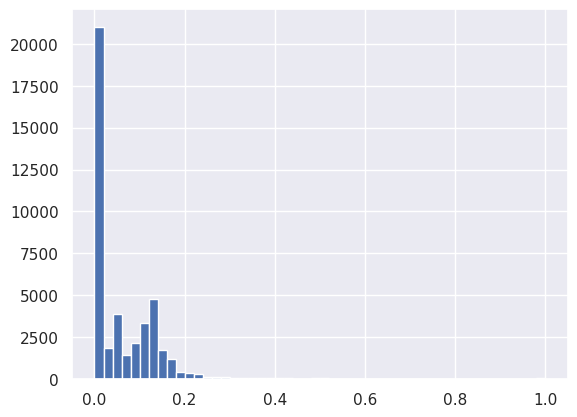

In [11]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50);

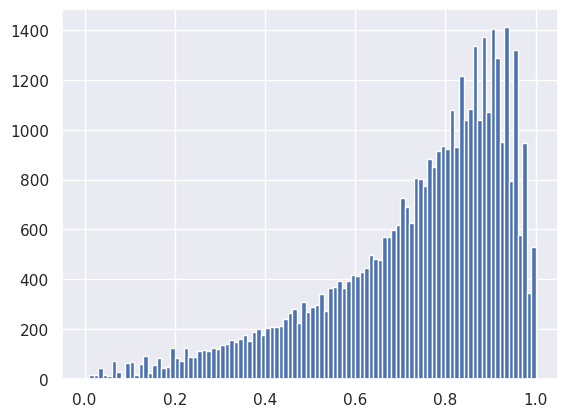

In [12]:
plt.hist(loan_data_defaults['CCF'], bins = 100);

In [13]:
# Create new variable which is 0 if recovery rate is 0 and 1 otherwise
loan_data_defaults['recovery_rate_0_1'] = \
np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
loan_data_defaults['recovery_rate_0_1'].head()

/tmp/ipykernel_17193/3011928495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = \


1     1
8     1
9     1
12    1
14    1
Name: recovery_rate_0_1, dtype: int64

## 4. LGD Model

### 4.1 Splitting Data

In [14]:


lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, \
lgd_targets_stage_1_train, lgd_targets_stage_1_test = \
train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate',
                                          'recovery_rate_0_1', 'CCF'], axis = 1), 
                 loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)




### 4.2 Preparing the Inputs

In [15]:
# List of all independent variables for the models
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

# List of the dummy variable reference categories. 
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [16]:
# Keep only the variabes needed
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

In [17]:
# Check for missing values
#lgd_inputs_stage_1_train.isnull().sum()


## Stage 1: Logistic Regression

### 4.3 Estimating the model

In [18]:


# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij



In [19]:
reg_lgd_st_1 = LogisticRegression_with_p_values()

In [20]:
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [22]:
#Note: most of the variables aren't statistically significant
# throwing them out won't affect the predicting power
# but we can keep them to save us effort
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table.head()

,Feature name,Coefficients,p_values
0,Intercept,-0.000077,NaN
1,grade:A,-0.000009,0.999911
2,grade:B,-0.000064,0.999251
3,grade:C,-0.000129,0.998434
4,grade:D,0.000023,0.999738



### 4.4 Testing the model

In [23]:
reg_lgd_st_1 = LogisticRegression_with_p_values()

In [24]:
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
feature_name = lgd_inputs_stage_1_train.columns.values


In [26]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table.head()

#Note: most of the variables aren't statistically significant
# throwing them out won't affect the predicting power
# but we can keep them to save us effort

,Feature name,Coefficients,p_values
0,Intercept,-0.000077,NaN
1,grade:A,-0.000009,0.999911
2,grade:B,-0.000064,0.999251
3,grade:C,-0.000129,0.998434
4,grade:D,0.000023,0.999738



### 4.4 Testing the model

In [27]:
# Keep only the needed variables
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = \
lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [28]:
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 0, 1, 1])

In [29]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)
y_hat_test_proba_lgd_stage_1

array([[0.39233199, 0.60766801],
       [0.38839126, 0.61160874],
       [0.54355124, 0.45644876],
       ...,
       [0.50275184, 0.49724816],
       [0.40724446, 0.59275554],
       [0.45601752, 0.54398248]])

In [30]:
# Take only the probability of recovery rate > 0
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]
y_hat_test_proba_lgd_stage_1

array([0.60766801, 0.61160874, 0.45644876, ..., 0.49724816, 0.59275554,
       0.54398248])

In [31]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test.copy()
lgd_targets_stage_1_test_temp.head()

178928    1
69814     1
101396    0
463268    1
253729    0
Name: recovery_rate_0_1, dtype: int64

In [32]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)
lgd_targets_stage_1_test_temp.head()

0    1
1    1
2    0
3    1
4    0
Name: recovery_rate_0_1, dtype: int64

In [33]:
df_actual_predicted_probs = \
pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)
# Concatenates two dataframes
df_actual_predicted_probs.head()

,recovery_rate_0_1,0
0,1,0.607668
1,1,0.611609
2,0,0.456449
3,1,0.555440
4,0,0.417088


In [34]:
# Rename columns
df_actual_predicted_probs.columns = \
['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index
df_actual_predicted_probs.head()


,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.607668
69814,1,0.611609
101396,0,0.456449
463268,1,0.555440
253729,0,0.417088


In [35]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.607668
69814,1,0.611609
101396,0,0.456449
463268,1,0.555440
253729,0,0.417088


### 4.5 Estimating the Accuracy of the Model

In [36]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = \
np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1,0)

cf_mtx = pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], 
                     df_actual_predicted_probs['y_hat_test_lgd_stage_1'], 
                     rownames = ['Actual'], colnames = ['Predicted'])
cf_mtx

Predicted,0,1
Actual,,
0,977,2785
1,682,4204


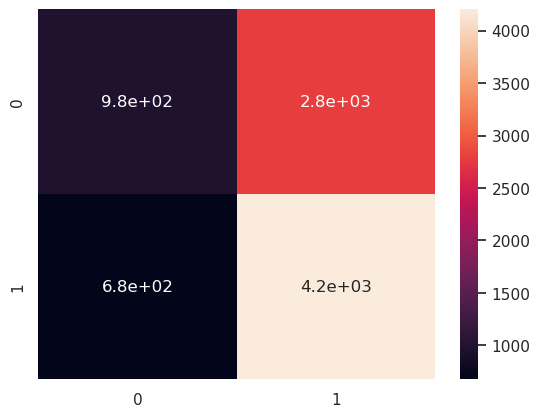

In [37]:
sns.heatmap(confusion_matrix(df_actual_predicted_probs['lgd_targets_stage_1_test'],\
                           df_actual_predicted_probs['y_hat_test_lgd_stage_1']), annot=True)
plt.show()

In [38]:
cf_mtx_perc = cf_mtx / df_actual_predicted_probs.shape[0]
cf_mtx_perc

Predicted,0,1
Actual,,
0,0.112974,0.322040
1,0.078862,0.486124


In [39]:
# Calculate Accuracy of the model
acc_rate = cf_mtx_perc.iloc[0,0] + cf_mtx_perc.iloc[1,1]
acc_rate

0.5990980573543015

In [40]:
fpr, tpr, thresholds = \
roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], 
          df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

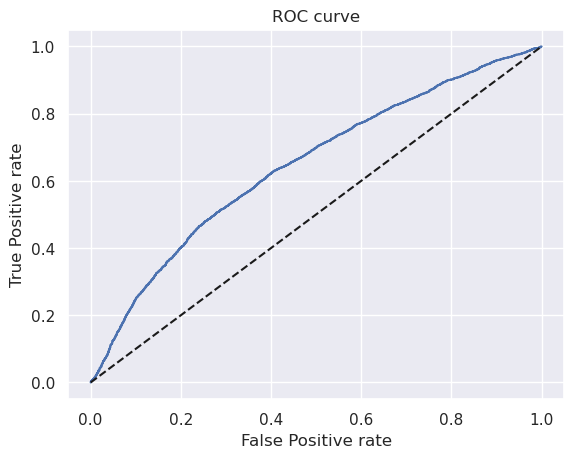

In [41]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')
plt.show()

In [42]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], 
                      df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6464703044404447

In [43]:
# Saving the Model
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.sav', 'wb'))

## Stage 2- Linear Regression

### 4.6 Estimating the model

In [44]:
# Only rows where the original recovery rate variable is greater than one
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [45]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, \
lgd_targets_stage_2_train, lgd_targets_stage_2_test = \
train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate',
                                        'recovery_rate_0_1', 'CCF'], axis = 1), 
                 lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [46]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [47]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [48]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [49]:
feature_name = lgd_inputs_stage_2_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table.head()

,Feature name,Coefficients,p_values
0,Intercept,0.240686,NaN
1,grade:A,-0.068269,0.0
2,grade:B,-0.050836,0.0
3,grade:C,-0.037481,0.0
4,grade:D,-0.027173,0.0


### 4.7 Model Validation

In [50]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)
lgd_inputs_stage_2_test.columns

Index(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding', 'initial_list_status:w',
       'term_int', 'emp_length_int', 'mths_since_issue_d',
       'mths_since_earliest_cr_line', 'funded_amnt', 'int_rate', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'total_acc', 'acc_now_delinq', 'total_rev_hi_lim'],
      dtype='object')

In [51]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [52]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test.copy()

In [53]:
lgd_targets_stage_2_test_temp = \
lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [54]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


/tmp/ipykernel_17193/1583748869.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


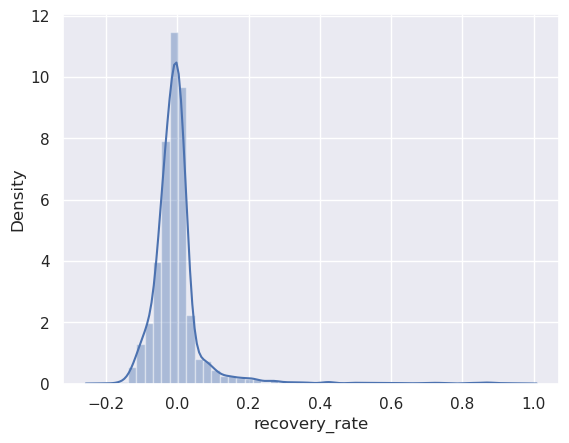

In [55]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)
plt.show()

In [56]:
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))


### 4.8 Combining Stage 1 and Stage 2

In [57]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_2_all

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

In [58]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.087477
std,0.049834
min,-0.007634
25%,0.065652
50%,0.101315
75%,0.123680
max,0.236973


In [59]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [60]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.087479
std,0.049831
min,0.000000
25%,0.065652
50%,0.101315
75%,0.123680
max,0.236973


## EAD Model

### 5.1 Estimating and Interpretation

In [61]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = \
train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1),\
                 loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [62]:
ead_inputs_train.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [63]:
ead_inputs_train = ead_inputs_train[features_all]
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

In [64]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [65]:
feature_name = ead_inputs_train.columns.values

In [66]:
feature_name = ead_inputs_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ["Intercept", reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan, np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,0.000000e+00
5,grade:E,-6.768713e-02,0.000000e+00
6,grade:F,-2.045907e-02,4.428795e-03
7,home_ownership:MORTGAGE,-6.343341e-03,2.632464e-03
8,home_ownership:NONE,-5.539064e-03,9.318931e-01
9,home_ownership:OTHER,-2.426052e-03,9.335820e-01


### 5.2 Model Validation

In [67]:
ead_inputs_test = ead_inputs_test[features_all]
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [68]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [69]:
ead_targets_test_temp = ead_targets_test
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [70]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


/tmp/ipykernel_17193/1484579568.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_targets_test - y_hat_test_ead)


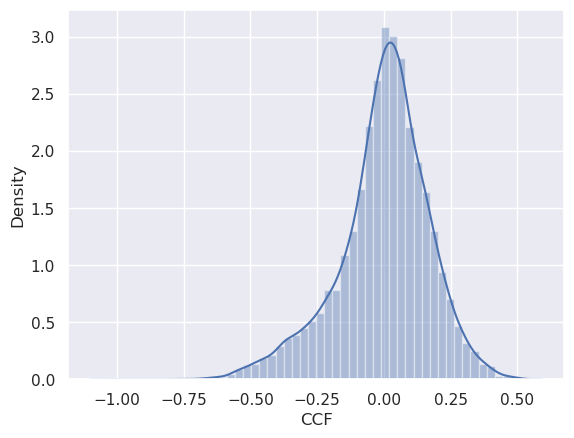

In [71]:
sns.distplot(ead_targets_test - y_hat_test_ead)
plt.show()

In [72]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [73]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead >1 , 1, y_hat_test_ead)

In [74]:

pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000



### 6. Expected Loss

In [75]:

### 6.1 Preprocess Data

In [76]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [77]:
loan_data_preprocessed.isnull().sum()

Unnamed: 0.1                                                            0
Unnamed: 0                                                              0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                            

In [78]:
# Fill the missing values
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [79]:
# Keep the needed variables
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

### 6.2 LGD

In [80]:
# Apply LGD stage 1 - Logistic regression model
loan_data_preprocessed['recovery_rate_st_1'] = \
reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [81]:
# Apply LGD stage 2 - Logistic regression model
loan_data_preprocessed['recovery_rate_st_2'] = \
reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [82]:
loan_data_preprocessed['recovery_rate'] = \
loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']


In [83]:
# Make sure all values between 0 and 1
loan_data_preprocessed['recovery_rate'] = \
np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = \
np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [84]:
# Keep the needed variables
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [85]:
# Apply LGD stage 1 - Logistic regression model
loan_data_preprocessed['recovery_rate_st_1'] = \
reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [86]:
# Apply LGD stage 2 - Logistic regression model
loan_data_preprocessed['recovery_rate_st_2'] = \
reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [87]:
loan_data_preprocessed['recovery_rate'] = \
loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [88]:
# Make sure all values between 0 and 1
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])


In [89]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']


In [90]:
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.919960
std           0.057504
min           0.659786
25%           0.873069
50%           0.898976
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

### 6.3 EAD

In [91]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)


In [92]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [93]:
# Calculate estimated EAD. 
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# Estimated EAD equals estimated CCF multiplied by funded amount.
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

In [94]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,1,0,1,1,0.086271,0.086271,0.913729,0.589922,2949.608449
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,1,0,0,1,0.084518,0.084518,0.915482,0.777773,1944.433378
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,1,0,1,1,0.080516,0.080516,0.919484,0.658306,1579.934302
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,1,0,1,1,0.095076,0.095076,0.904924,0.660656,6606.559612
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,1,0,1,1,0.088547,0.088547,0.911453,0.708211,2124.631667


### 6.4 PD

In [95]:
# Import data to apply the PD model
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [96]:
# Concatenate the two dataframes along the rows.
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [97]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [98]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86']
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [99]:
# Keep the needed variables
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)


In [100]:
loan_data_inputs_pd_temp.shape


(466285, 84)

In [101]:
#Import pickle
reg_pd = pickle.load(open('pd_model.sav', 'rb'))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [102]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
loan_data_inputs_pd['PD'].head()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Unnamed: 0
427211    0.029586
206088    0.092148
136020    0.037359
412305    0.204328
36159     0.200847
Name: PD, dtype: float64

In [103]:
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.109307
std           0.070917
min           0.007314
25%           0.056064
50%           0.093492
75%           0.146558
max           0.635818
Name: PD, dtype: float64

In [104]:
# Concate PD with LGD and EAD
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)

loan_data_preprocessed_new.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,PD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,1,0,1,0,0,0,0,0,0,0.164761
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,1,0,0,0,0,0,0,0.282340
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,1,0,0,0,0,0,0,0.229758
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,1,0,0,0,0,0,0,0.208892
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,1,0,0,0,0,0,0,0.129556


### 6.5 EL


In [105]:
# Calculate Expected Loss. EL = PD * LGD * EAD
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * \
loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [106]:
EL = loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']]
EL.head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.164761,0.913729,2949.608449,444.053181
1,2500,2500,0.282340,0.915482,1944.433378,502.592155
2,2400,2400,0.229758,0.919484,1579.934302,333.775277
3,10000,10000,0.208892,0.904924,6606.559612,1248.848487
4,3000,3000,0.129556,0.911453,2124.631667,250.884853


In [107]:
EL.describe()


,funded_amnt,funded_amnt,PD,LGD,EAD,EL
count,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000
mean,14291.801044,14291.801044,0.109307,0.919960,10814.846760,1075.060311
std,8274.371300,8274.371300,0.070917,0.057504,6935.184562,1090.601570
min,500.000000,500.000000,0.007314,0.659786,190.347372,9.542984
25%,8000.000000,8000.000000,0.056064,0.873069,5495.101413,355.612912
50%,12000.000000,12000.000000,0.093492,0.898976,9208.479591,704.954286
75%,20000.000000,20000.000000,0.146558,1.000000,14692.844549,1393.884458
max,35000.000000,35000.000000,0.635818,1.000000,35000.000000,11909.915162


In [108]:
EL.sum()

funded_amnt    6.664052e+09
funded_amnt    6.664052e+09
PD             5.096814e+04
LGD            4.289636e+05
EAD            5.042801e+09
EL             5.012845e+08
dtype: float64

In [109]:
total_EL = EL['EL'].sum()
total_EL

501284496.93877804

In [110]:
total_funded = EL['funded_amnt'].sum()[0]
total_funded

6664052450

In [111]:
ratio_EL = total_EL / total_funded
ratio_EL

0.07522217159902125

# THE END